# Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from nsde_bmm.buffers import Generator
from nsde_bmm.architecture import NSDE
from nsde_bmm.utils import neg_log_likelihood, mc_moments

FloatTensor = torch.FloatTensor

%matplotlib inline

# Load Data

In [16]:
# Visualize Data
dt = .05 # time increment
N_train = 100# use first 100 steps for training

t = np.arange(0, 10, dt) 
X = np.load("data/stochastic_lotka_data.npy")
scale_m = np.mean(X.reshape(-1,2),0)
scale_std = np.std(X.reshape(-1,2),0)
X=(X-np.mean(X.reshape(-1,2),0)) /(np.std(X.reshape(-1,2),0))

generator = Generator(X[:N_train])

# Train

In [3]:
nsde = NSDE()  
opt = torch.optim.Adam(nsde.parameters(), lr=1e-3)

horizon=10
batch_size = 16

history = []
best_nll = np.inf

for i in range(3000):
    opt.zero_grad()
    snippet = FloatTensor(generator(horizon, batch_size))

    m = [snippet[:, 0, :]] 
    P = [torch.eye(2).expand(batch_size, 2, 2)*1e-6] 
    nll = 0
    for h in range(horizon-1): 
        m_next, P_next = nsde.next_moments(m[-1], P[-1]) 
        m.append(m_next), P.append(P_next)
        nll_ = neg_log_likelihood(snippet[:, h+1], m_next, P_next) 
        nll = nll + nll_

    nll = nll.mean()
    history.append(nll.data)
    nll.backward()
    opt.step()

    # testing
    if i%50==0:
        with torch.no_grad():
            m = [FloatTensor([X[0,0]])] 
            P = [torch.eye(2).expand(1, 2, 2)*1e-6] 
            for t in range(N_train-1): # 
                m_next, P_next = nsde.next_moments(m[-1], P[-1])
                m.append(m_next.detach()), P.append(P_next.detach())

            m = torch.stack(m).view(-1,2)
            m = m.unsqueeze(1).repeat(1, X.shape[1], 1)
            P = torch.stack(P).view(-1, 2,2)
            P = P.unsqueeze(1).repeat(1, X.shape[1], 1, 1)
            nll = neg_log_likelihood(FloatTensor(X[:N_train]).view(-1, 2),
                                               m.view(-1, 2),
                                               P.view(-1, 2, 2))
            current_nll = nll.mean().detach().numpy()
            if current_nll < best_nll:
                best_nll = current_nll
                print("New best NLL {:.2f} at iter {:1.0f}".format(best_nll, i))
                torch.save(nsde.state_dict(), "weights/best")
      

/home/viktor1234/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_548/1080437926.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  m = [FloatTensor([X[0,0]])]


New best NLL 923.97 at iter 0
New best NLL 12.62 at iter 50
New best NLL 6.86 at iter 100
New best NLL 6.23 at iter 150
New best NLL 6.06 at iter 350
New best NLL 5.65 at iter 400
New best NLL 4.77 at iter 450
New best NLL 3.97 at iter 500
New best NLL 3.52 at iter 550
New best NLL 3.01 at iter 600
New best NLL 2.48 at iter 650
New best NLL 2.37 at iter 700
New best NLL 1.66 at iter 750
New best NLL 0.99 at iter 800
New best NLL 0.74 at iter 850
New best NLL 0.45 at iter 900
New best NLL 0.25 at iter 950
New best NLL 0.06 at iter 1000
New best NLL -0.03 at iter 1050
New best NLL -0.15 at iter 1100
New best NLL -0.48 at iter 1150
New best NLL -0.61 at iter 1200
New best NLL -0.87 at iter 1250
New best NLL -0.89 at iter 1300
New best NLL -1.20 at iter 1350
New best NLL -1.42 at iter 1400
New best NLL -1.45 at iter 1450
New best NLL -1.49 at iter 1500
New best NLL -1.74 at iter 1550
New best NLL -1.97 at iter 1600
New best NLL -2.13 at iter 1650
New best NLL -2.35 at iter 1750
New best NL

# Visualize

In [4]:
nsde = NSDE()  
PATH = "weights/best"
nsde.load_state_dict(torch.load(PATH))

# calculate true mean and covariance 
X_true = FloatTensor(X)
m_true = torch.mean(X_true, 1)
P_true = X_true - m_true.unsqueeze(1).repeat(1, 128, 1)
P_true = (P_true.view(-1, 2, 1)@P_true.view(-1, 1, 2)).view(-1, 128, 2, 2)
P_true = torch.sum(P_true, 1)/(128-1)
P_cholesky_true = torch.linalg.cholesky(P_true+torch.eye(2).unsqueeze(0)*1e-6)

with torch.no_grad():
    # predict mean and covariance with BMM algorithm
    m_BMM = [FloatTensor([X[0,0]])] # starting point at t=0
    P_BMM = [torch.eye(2).expand(1, 2, 2)*1e-6] # Diagonal Covariance \approx Dirac Delta
    for t in range(199): # 
        m_next, P_next = nsde.next_moments(m_BMM[-1], P_BMM[-1])
        m_BMM.append(m_next.detach()), P_BMM.append(P_next.detach())
    m_BMM = torch.stack(m_BMM).view(-1,2)
    P_BMM = torch.stack(P_BMM).view(-1,2,2)
    P_BMM_cholesky = torch.linalg.cholesky(P_BMM)

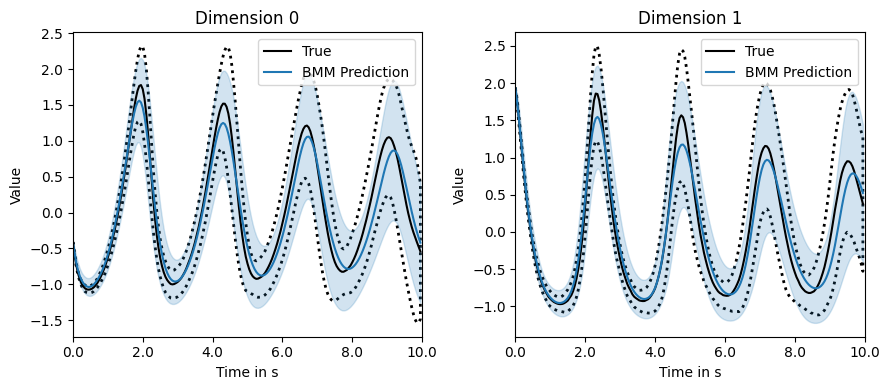

In [5]:
# compare BMM approximation to ground truth dynamics
f, ax = plt.subplots(1,2, figsize=(9,4))
for c, a in enumerate(ax.flatten()):
    a.plot(m_true[:,c], c="black", label="True" )
    a.fill_between(np.arange(len(m_true)), 
                     m_true[:, c]+P_cholesky_true[:, c, c], 
                     m_true[:, c]-P_cholesky_true[:, c, c],  
                     facecolor="white", 
                     edgecolor="black", 
                     lw=2, 
                     linestyle=":", )
    
    a.plot(m_BMM[:, c], color="C{}".format(0), label="BMM Prediction")
    a.fill_between(np.arange(len(m_BMM)), 
                     m_BMM[:, c]+P_BMM_cholesky[:, c, c], 
                     m_BMM[:, c]-P_BMM_cholesky[:, c, c],  
                     color="C{}".format(0), alpha=.2,)
    
    a.set_title("Dimension {}".format(c))
    a.set_xlim(0,200)
    a.set_xticks(np.linspace(0,200,6))
    a.set_xticklabels(np.linspace(0,10,6))
    a.set_xlabel("Time in s")
    a.set_ylabel("Value")
    a.legend()
plt.tight_layout()